## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is provided below:

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### 1.2 Imports

In [4]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from transformers import (MaskFormerForInstanceSegmentation, MaskFormerImageProcessor)

# custom imports
import utils.data_handler as dh
import utils.mri_common as mri_common
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics
import utils.maskformer_train as mft

from utils.mri_common import SliceDirection
from utils.maskformer_dataset import MaskformerMRIDataset, collate_fn
from utils.maskformer_evaluation import MaskFormerEvaluation, calc_slice_metrics, calc_subject_metrics
from utils.maskformer_inference import MaskFormerInference, get_mask_from_segm_result
from utils.data_handler import DataHandler, MriType, LatentVector, StructuralScan
from utils.maskformer_train import MaskFormerTrain

np.set_printoptions(precision=16)

# seeding
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

data_handler = DataHandler()

### 1.3 Initializations (important!)

Initialize parameters for the training

In [5]:
# identifier for a specific run. this will be appended in the files that we are generating for this training
TRAIN_ID = "sample_training test"
print("Train Id", TRAIN_ID)

# Specify the type of 2D slice orientation that you want to feed into the directory
# other options: SliceDirection.CROSS_FRONT, SliceDirection.CROSS_SIDE
ORIENTATION = SliceDirection.DEPTH

# specify None if you want to include all slices in the DataLoader
NUM_SLICES = 10

# training width and height
HEIGHT, WIDTH = 326, 386

Train Id sample_training test


Initialize parameters for training a new model

In [6]:
# set to true if we want to start a new training
RETRAIN = False

# directory to save the model and files
TRAIN_DIR_PREFIX = "maskformer/latent_space_representation_2"
BATCH_SIZE = 2
N_EPOCH = 5

# interval for saving of model
SAVE_INTERVAL = 3

Initialize parameters for loading an existing model

In [7]:
# set to true if we want to load an existing model
LOAD_MODEL = True

# load existing model:
MODEL_DIR_PREFIX = f"maskformer/latent_space_representation"
MODEL_FILE_NAME = f"model_epoch14.pt"

Initalize parameters for calculating metrics

In [8]:
# set directory of the model source (if retrieving) or destination (if recalculating)
# this can come from a different folder within the training folder
METRICS_DIR_PREFIX = "maskformer/latent_space_representation_2"

# set to true if we want to calculate metrics
RECALCULATE_VAL_METRICS = True
VAL_METRICS_FILENAME = f"metrics_val_{TRAIN_ID}.joblib"

This part will check if the TRAINING directory specified already exists and whether the person intends to overwrite the files when retraining

In [9]:
dir_exists = data_handler.dir_exists(train_dir_prefix=TRAIN_DIR_PREFIX)
if dir_exists:
  answer = input(f"Chosen train_dir_prefix {TRAIN_DIR_PREFIX} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new training directory...")
    TRAIN_DIR_PREFIX = mri_common.create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {TRAIN_DIR_PREFIX}")

Chosen train_dir_prefix maskformer/latent_space_representation_2 has files stored. 
Are you sure you want to overwrite this folder? Reply YES: y

Files will be saved using training_dir_prefix: maskformer/latent_space_representation_2


This part will check if the METRICS directory already exists and whether the person intends to overwrite the files for recalculation


In [10]:
dir_exists = data_handler.dir_exists(train_dir_prefix=METRICS_DIR_PREFIX)
if dir_exists:
  answer = input(f"Chosen metrics_dir_prefix {METRICS_DIR_PREFIX} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new metrics directory...")
    METRICS_DIR_PREFIX = mri_common.create_train_dir_by_date()

print(f"\nFiles will be saved using metrics_dir_prefix: {METRICS_DIR_PREFIX}")

Chosen metrics_dir_prefix maskformer/latent_space_representation_2 has files stored. 
Are you sure you want to overwrite this folder? Reply YES: y

Files will be saved using metrics_dir_prefix: maskformer/latent_space_representation_2



## 2. Process 2D data

### 2.0 Initialize parameters

### 2.1 Load and select data

In [11]:
# extract 2d slices from each 3d volume
lsv_3d_files, lsv_3d_dir = data_handler.list_mri_in_dir(mri_type=MriType.LATENT_SPACE_VECTORS_NORM, return_dir=True)
print("latent space vector 3d data directory", lsv_3d_dir)

mri directory /content/data/latent_space_vectors_annot_reduced_norm
latent space vector 3d data directory /content/data/latent_space_vectors_annot_reduced_norm


In [ ]:
# generate 2d slices
data_dir = data_handler.data_dir
output_dir = os.path.join(data_dir, "lsv_2d_vectors")
data_dir_train, data_dir_val, data_dir_test = mri_common.generate_2d_slices(
    input_dir=lsv_3d_dir,
    output_dir=output_dir,
    orientation=ORIENTATION
)

loaded_3d_mri_dir_train /content/data/latent_space_vectors_annot_reduced_norm/train
loaded_3d_mri_dir_val /content/data/latent_space_vectors_annot_reduced_norm/val
loaded_3d_mri_dir_test /content/data/latent_space_vectors_annot_reduced_norm/test
Extracting 2D slices from 3D volumes (now is a good time to take 5 min coffee break ...)


  0%|          | 0/3 [00:00<?, ?it/s]

Working on /content/data/latent_space_vectors_annot_reduced_norm/train --> /content/data/lsv_2d_vectors/train/depth


  0%|          | 0/352 [00:00<?, ?it/s]

Working on /content/data/latent_space_vectors_annot_reduced_norm/val --> /content/data/lsv_2d_vectors/val/depth


  0%|          | 0/120 [00:00<?, ?it/s]

Working on /content/data/latent_space_vectors_annot_reduced_norm/test --> /content/data/lsv_2d_vectors/test/depth


  0%|          | 0/116 [00:00<?, ?it/s]

In [17]:
train_2d = data_handler.list_mri_in_dir(local_path=data_dir_train)
val_2d = data_handler.list_mri_in_dir(local_path=data_dir_val)
test_2d = data_handler.list_mri_in_dir(local_path=data_dir_test)

print("full train dataset length", len(train_2d))
print("full val dataset length", len(val_2d))
print("full test dataset length", len(test_2d))

mri directory /content/data/lsv_2d_vectors/train/depth
mri directory /content/data/lsv_2d_vectors/val/depth
mri directory /content/data/lsv_2d_vectors/test/depth
full train dataset length 51392
full val dataset length 17520
full test dataset length 16936


#### Using a small portion of data for efficient testing

In [18]:
# initialize filenames for saving a smaller sample (for record keeping)
train_list = f"data_train_{TRAIN_ID}.txt"
val_list   = f"data_val_{TRAIN_ID}.txt"
test_list   = f"data_test_{TRAIN_ID}.txt"
train_list, val_list, test_list

('data_train_sample_training test.txt',
 'data_val_sample_training test.txt',
 'data_test_sample_training test.txt')

In [19]:
# select patent id range. 0 to 88 for entire range
all_subjs = mf_utils.get_all_subj_ids(data_dir_train)
subj_total = len(all_subjs)
print("total subjects", subj_total)

subj_id_min = 0
subj_id_max = subj_total + 1

total subjects 88


In [20]:
# set num_slice = None to select all slices
# this will take sample slices starting from the middle
file_no_min, file_no_max = mf_utils.get_file_idx_bounds(orientation=ORIENTATION)
file_no_min, file_no_max

(0, 147)

In [21]:
# obtain subset of training files
train_data_list = mf_utils.get_subset_files(train_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
print(f"Number of unique training samples: {len(train_data_list)}")

# obtain subset of validation files
val_data_list = mf_utils.get_subset_files(val_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
print(f"Number of unique validation samples: {len(val_data_list)}")

# obtain subset of test files
test_data_list = mf_utils.get_subset_files(test_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
print(f"Number of unique test samples: {len(test_data_list)}")

# save the sample files for record keeping. we can use this to
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=TRAIN_DIR_PREFIX,
                       data='\n'.join(str(item) for item in train_data_list))

data_handler.save_text(file_name = val_list,
                       train_dir_prefix=TRAIN_DIR_PREFIX,
                       data='\n'.join(str(item) for item in val_data_list))


data_handler.save_text(file_name = test_list,
                       train_dir_prefix=TRAIN_DIR_PREFIX,
                       data='\n'.join(str(item) for item in test_data_list))


Number of unique training samples: 12848
Number of unique validation samples: 4380
Number of unique test samples: 4234


### 2.2 Create Custom PyTorch Dataset


In [22]:
# set maskformer processor
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [23]:
# initalize maskformerprocessor:
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

# load sample list from text file saved from 2.1
train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=TRAIN_DIR_PREFIX)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=TRAIN_DIR_PREFIX)
test_data_list = data_handler.load_text_as_list(file_name = test_list, train_dir_prefix=TRAIN_DIR_PREFIX)

# Get the first file name from the train_data_list
orig_dim = data_handler.load_mri(subj_id=mri_common.get_mri_subj(train_data_list[0]),
                                 local_path=data_dir_train,
                                 file_no=mri_common.get_mri_file_no(train_data_list[0]),
                                 struct_scan=LatentVector.LATENT_VECTOR_1).shape
# define data transforms
train_transform = A.Compose([
    A.Resize(width=WIDTH, height=HEIGHT),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

In [24]:
# create datasets
train_dataset = MaskformerMRIDataset(
    data_dir=data_dir_train,
    data_list=train_data_list,
    processor=processor,
    data_type="latent_space_vector",
    transform=train_transform,
    augment=True
)
val_dataset = MaskformerMRIDataset(
    data_dir=data_dir_val,
    data_list=val_data_list,
    processor=processor,
    data_type="latent_space_vector",
    transform=train_transform,
    augment=False
)
test_dataset = MaskformerMRIDataset(
    data_dir=data_dir_test,
    data_list=test_data_list,
    processor=processor,
    data_type="latent_space_vector",
    transform=train_transform,
    augment=False
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### 2.3 QC dataset

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([1, 326, 386])
class_labels torch.Size([1])
dataset length 12848
class labels tensor([0])


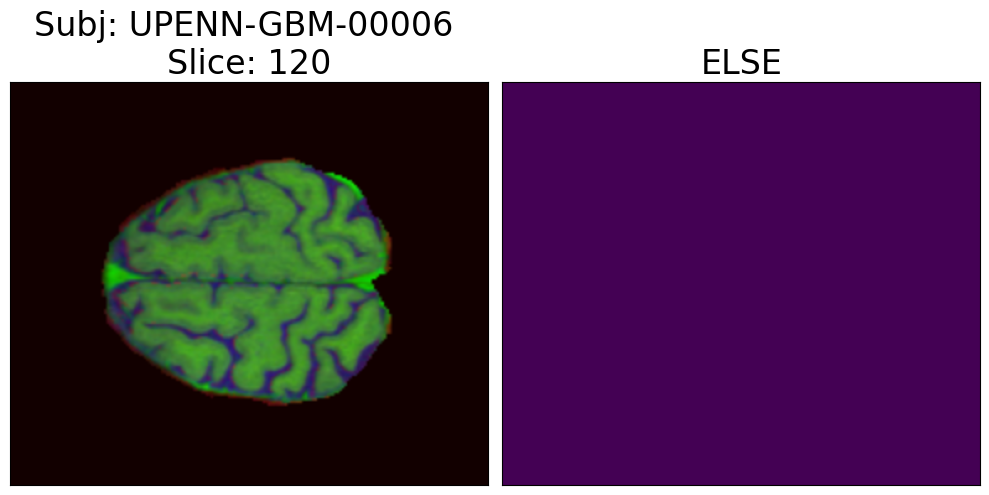

In [25]:
# print info about a dataset for any test index
train_input = mft.peek(train_dataset, 120)

# plot the input and segmentation masks
train_img_title = f"Subj: {train_input['subj_no']} \nSlice: {train_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=train_input["class_labels"].tolist(),
             pixel_values = train_input['pixel_values'].numpy(),
             mask_labels = train_input['mask_labels'],
             title = train_img_title)

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([2, 326, 386])
class_labels torch.Size([2])
dataset length 4380
class labels tensor([0, 2])


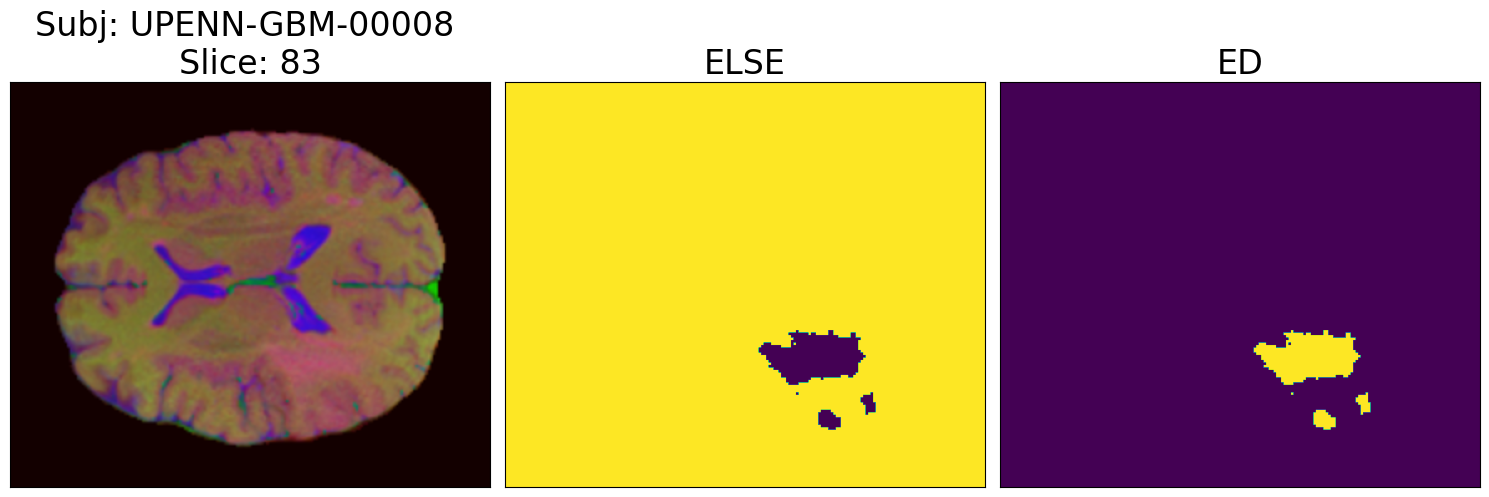

In [26]:
# peek at the val dataset
val_input = mft.peek(val_dataset, 83)

# plot val dataset
val_img_title = f"Subj: {val_input['subj_no']} \nSlice: {val_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=val_input["class_labels"].tolist(),
             pixel_values = val_input['pixel_values'].numpy(),
             mask_labels = val_input['mask_labels'],
             title= val_img_title)

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([4, 326, 386])
class_labels torch.Size([4])
dataset length 4234
class labels tensor([0, 1, 2, 3])


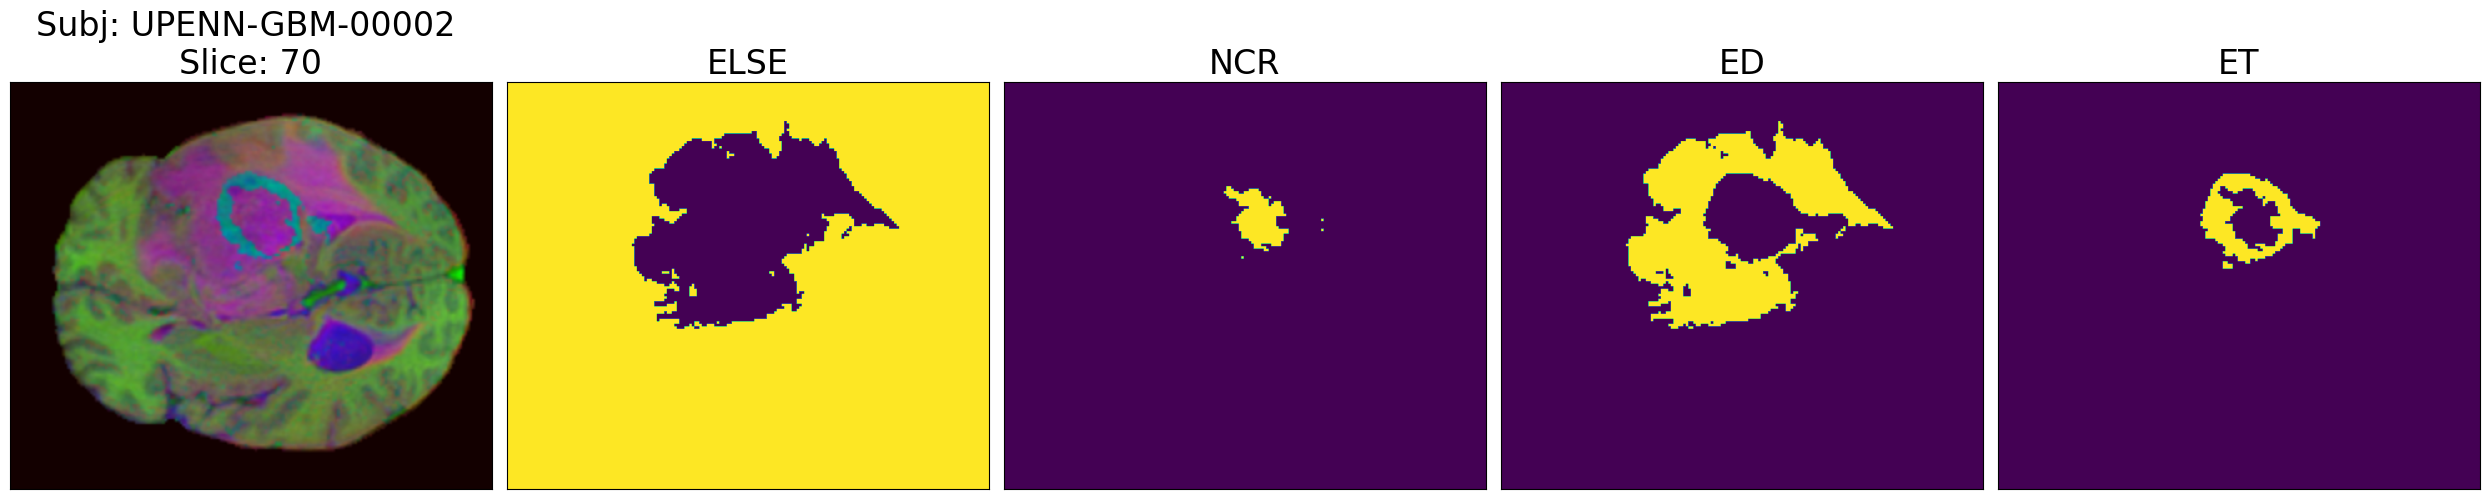

In [27]:
# peek at the test dataset
test_input = mft.peek(test_dataset, 70)

# plot val dataset
test_img_title = f"Subj: {test_input['subj_no']} \nSlice: {test_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=test_input["class_labels"].tolist(),
             pixel_values = test_input['pixel_values'].numpy(),
             mask_labels = test_input['mask_labels'],
             title= test_img_title)

## 3. Fine-tuning Model

### 3.1 Define the model

In [28]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the label dictionary required by the maskformer model
id2label, label2id = mf_utils.get_label_dictionary(mri_common.SEGMENTS)
print(id2label)
print(label2id)

# Load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-small-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-small-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# load saved model if needed
if LOAD_MODEL == True:
    model = data_handler.load_torch(file_name=MODEL_FILE_NAME, train_dir_prefix=MODEL_DIR_PREFIX, device=device)

In [30]:
# add outputs
model.config.output_attentions = True
# reset weight of losses
# model.config.mask_weight  = 2.0
# model.config.dice_weight = 0.1

# print model config
configuration = model.config
print(configuration)

MaskFormerConfig {
  "_name_or_path": "zuppif/maskformer-swin-small-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "depths": [
      2,
      2,
      18,
      2
    ],
    "drop_path_rate": 0.3,
    "embed_dim": 96,
    "hidden_size": 768,
    "image_size": 224,
    "in_channels": 3,
    "model_type": "swin",
    "num_heads": [
      3,
      6,
      12,
      24
    ],
    "out_features": [
      "stage4"
    ],
    "out_indices": [
      4
    ],
    "path_norm": true,
    "pretrain_img_size": 224,
    "window_size": 7
  },
  "ce_weight": 1.0,
  "cross_entropy_weight": 1.0,
  "decoder_config": {
    "max_position_embeddings": 1024,
    "model_type": "detr",
    "scale_embedding": false
  },
  "dice_weight": 1.0,
  "fpn_feature_size": 256,
  "id2label": {
    "0": "ELSE",
    "1": "NCR",
    "2": "ED",
    "3": "ET"
  },
  "init_std": 0.02,
  "init_xavier_std": 1.0,
  "label2id": {
    "ED": 2,
    "ELSE": 0,
    "ET": 3,
    "NCR

In [31]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(BATCH_SIZE, 3, WIDTH, HEIGHT), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [2, 3, 386, 326]     [2, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [2, 3, 386, 326]     [2, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [2, 3, 386, 326]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [2, 3, 386, 326]     [2, 96, 97, 82]      48,840,138           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [2, 96, 97, 82]      --                   4,304,640            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.3 Train the model

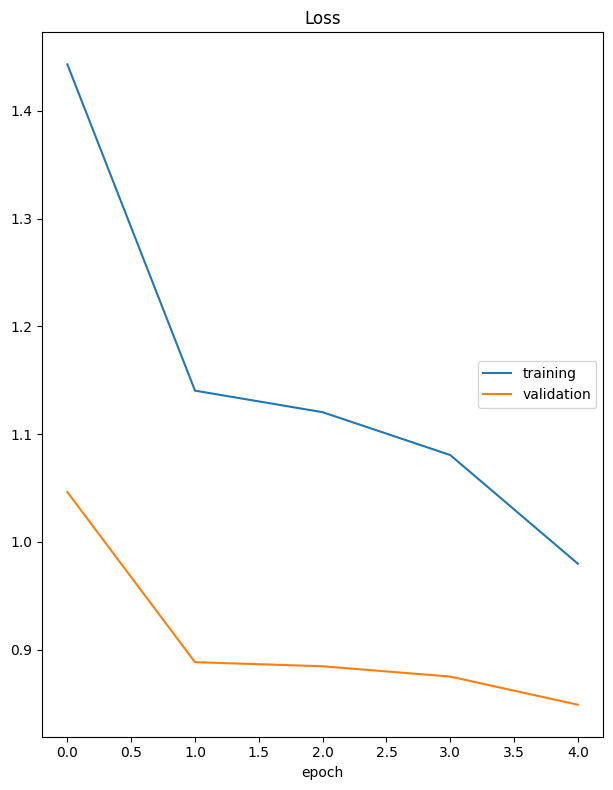

Loss
	training         	 (min:    0.980, max:    1.443, cur:    0.980)
	validation       	 (min:    0.849, max:    1.046, cur:    0.849)


In [ ]:
mf_train = MaskFormerTrain(model=model, n_epoch=N_EPOCH)
if RETRAIN:
    mf_train.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, train_id=TRAIN_ID, train_dir_prefix=TRAIN_DIR_PREFIX)

## 4. Evaluation

### 4.1 Make prediction on one sample

#### 4.1.1 Model prediction and visualization on one sample

In [32]:
# define a transform without resizing
org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# create a test data loader without shuffling
QC_TYPE = 'val'
# QC_TYPE = 'test'

# fixed batch size for now
if QC_TYPE == 'train':
    # uses the same transformation during training
    qc_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_dir=data_dir_train, data_type="latent_space_vector", data_list=train_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
elif QC_TYPE == 'val':
    # uses the same transformation during training
    qc_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_dir=data_dir_val, data_type="latent_space_vector", data_list=val_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
else:
    # uses the same transformation during training
    qc_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_dir=data_dir_test, data_type="latent_space_vector", data_list=test_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [33]:
# TO QC a specific subj and a specific file no, search for the index in the datasetlist
target_subj = "UPENN-GBM-00054"
test_file_no = 90

# for this example, we are trying to find the file from the val_data_list
# find the index/indices in val_data_list corresponding to the 2d slices for the specified patient
subj_indices = [index for index, file_name in enumerate(val_data_list) if target_subj in file_name]

assert test_file_no < file_no_max and test_file_no > file_no_min, "test file should be within the specified sample slice"

# if using a smaller sample, start counting from file_no_min
offset = test_file_no - file_no_min

# get relative index of test_file_no
target_file_no = subj_indices[0] + offset
target_batch = int(target_file_no//BATCH_SIZE)
test_idx = target_file_no%BATCH_SIZE
print("target batch", target_batch)
print("test idx", test_idx)

target batch 410
test idx 0


In [34]:
# we can also override target_batch and test_idx if testing randomly
# target_batch = 3
# test_idx = 3

for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)
  else:
    print(k, len(v))

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_labels = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]
print(test_subj)

pixel_values torch.Size([2, 3, 326, 386])
pixel_mask torch.Size([2, 326, 386])
class_labels 2
mask_labels 2
subj_no 2
file_no 2
UPENN-GBM-00054_90


In [35]:
# prepare transform to for inferencing. the setup should be the same as train_transform
predict_transform = A.Compose([
    A.Resize(width=WIDTH, height=HEIGHT),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# instantiate MaskFormerInference class to perform prediction
test_mf_inference=MaskFormerInference(data_dir=data_dir_val,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)


# result = this is the method that runs MaskFormer post_process_semantic_segmentation
outputs, batch_results = test_mf_inference.predict_segm(test_batch, batch_size=BATCH_SIZE)

# use test_idx to get results from batch
results = batch_results[test_idx]

for segment_info in results['segments_info']:
    print(segment_info)
print("segmentation result shape", results['segmentation'].shape)
print("segmentation unique values", np.unique( results['segmentation']))

mri directory /content/data/lsv_2d_vectors/val/depth
{'id': 0, 'label_id': 2, 'was_fused': False, 'score': 0.895297}
{'id': 1, 'label_id': 3, 'was_fused': False, 'score': 0.929255}
{'id': 2, 'label_id': 0, 'was_fused': False, 'score': 0.986579}
{'id': 3, 'label_id': 1, 'was_fused': False, 'score': 0.766987}
segmentation result shape torch.Size([326, 386])
segmentation unique values [-1.  0.  1.  2.  3.]


In [ ]:
# Obtain labels in true, predict, intersection and union
labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )

# remove duplicates
labels_pred = list(set(labels_pred))
labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:", labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE', 'NCR', 'ED', 'ET']
Predicted labels: ['NCR', 'ED', 'ELSE', 'ET']
All labels: ['ED', 'ELSE', 'NCR', 'ET']
Common labels: ['NCR', 'ED', 'ELSE', 'ET']


#### 4.1.2 QC Resized Transform

In [36]:
# obtain one batch of original data.
# here we use org_dataloader which was initialized in section 4.1.1
# recall that this is the dataloader which does not resize the image
for ibatch, batch in enumerate(org_dataloader):
    if ibatch == target_batch:
        org_batch = batch
        break
    else:
        continue

org_image =  org_batch["pixel_values"][test_idx]
org_mask_labels = org_batch["mask_labels"][test_idx]
org_class_labels = org_batch["class_labels"][test_idx]
org_subj = org_batch["subj_no"][test_idx] + "_" +  org_batch["file_no"][test_idx]
print(org_subj)

UPENN-GBM-00054_90


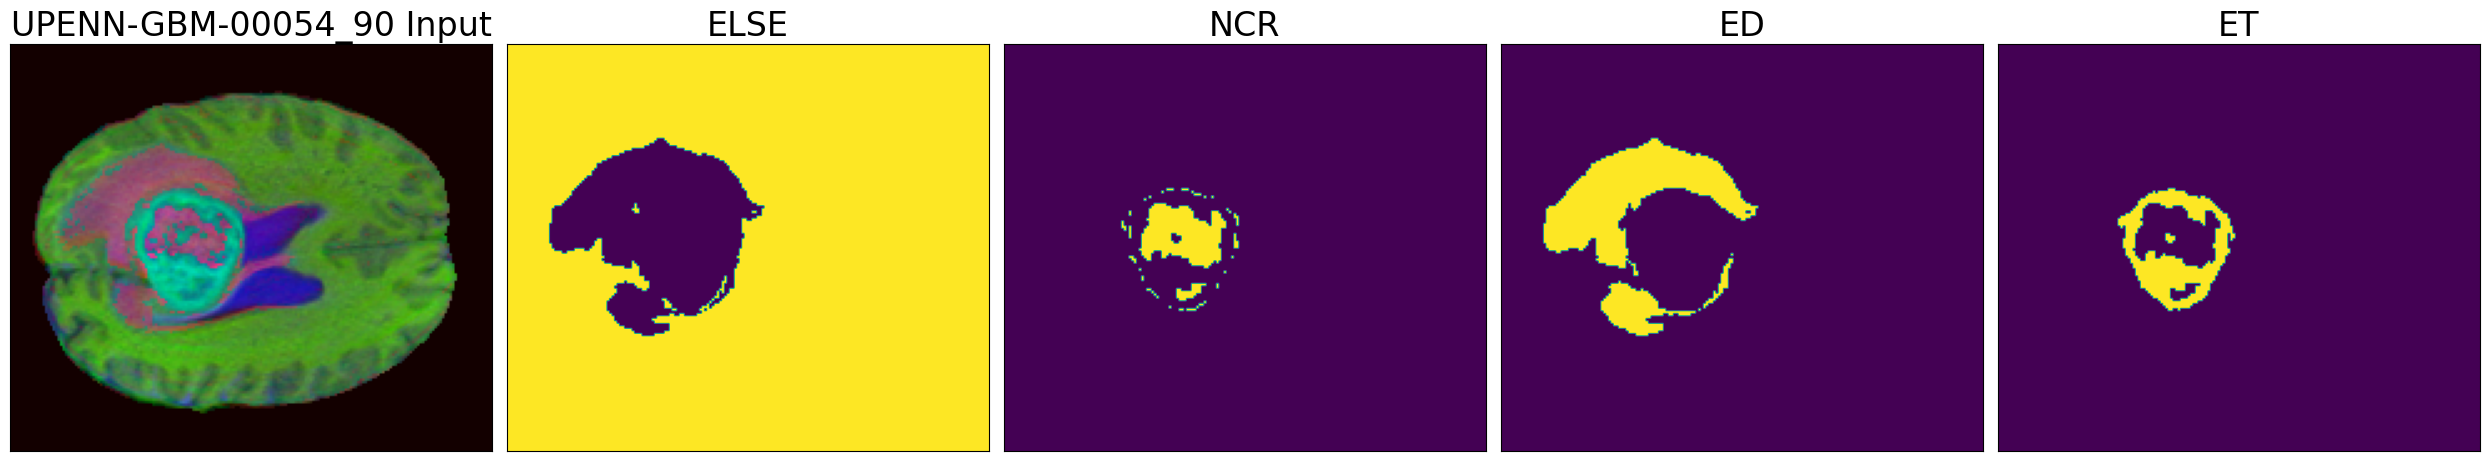

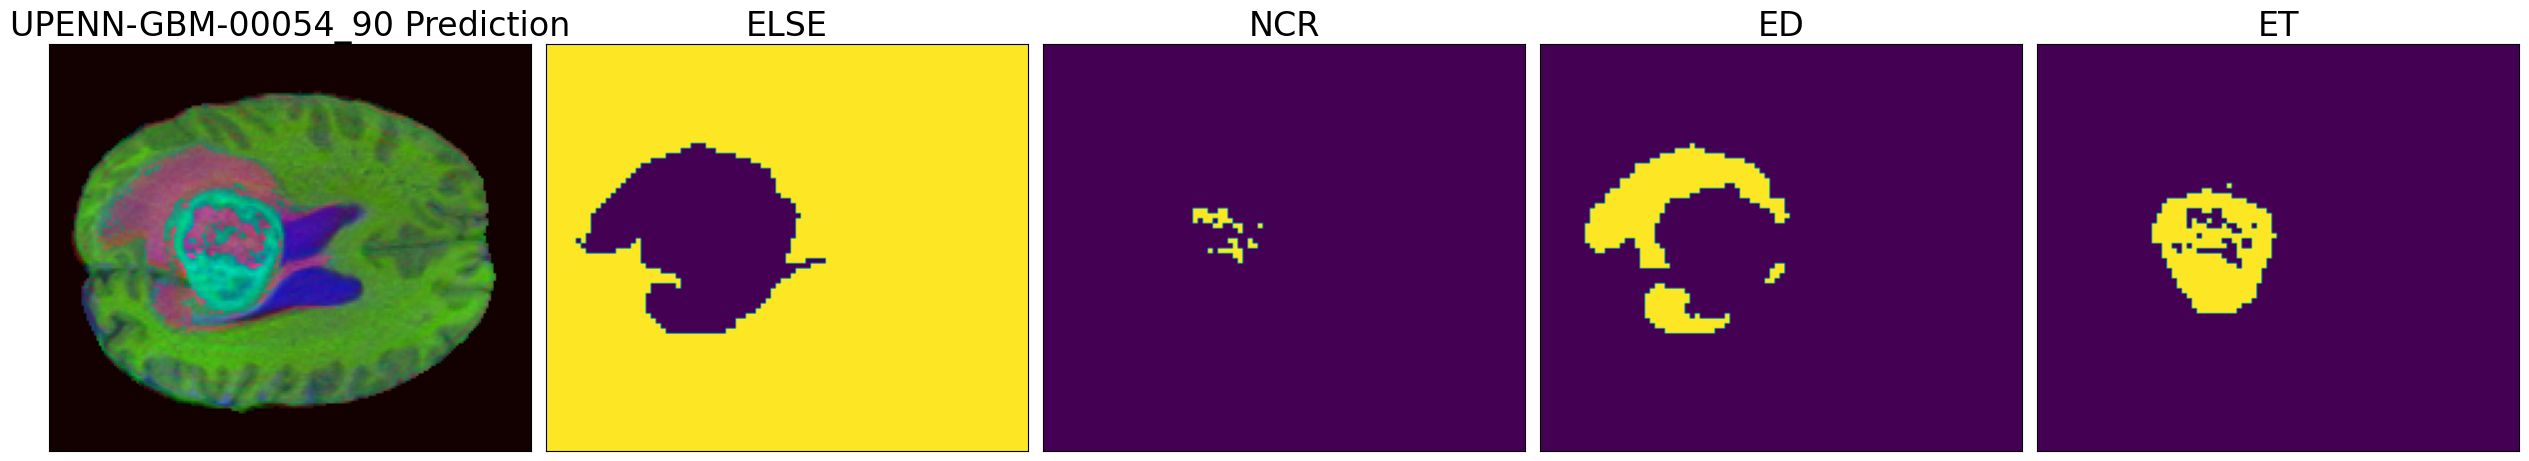

In [37]:
# resize predicted mask from 4.1.1 to original size
pred_mask_labels, pred_class_labels = get_mask_from_segm_result(segm_result=results)
pred_mask_labels_rs = mf_utils.resize_mask(pred_mask_labels, orig_dim)

# plot input mask labels
org_input_class_labels = org_class_labels.numpy()
mf_utils.plot_mask_labels(class_labels= org_input_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = org_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = pred_mask_labels_rs,
             title= test_subj + " Prediction")



In [38]:
# compare the two segmentatiosn
org_segmentation = mf_utils.mask_to_segmentation(mask_labels=org_mask_labels, class_labels=org_input_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=pred_mask_labels_rs, class_labels=pred_class_labels)

print("orig segmentation shape", org_segmentation.shape)
print("pred segmentation shape", pred_segmentation.shape)

orig segmentation shape (163, 193)
pred segmentation shape (163, 193)


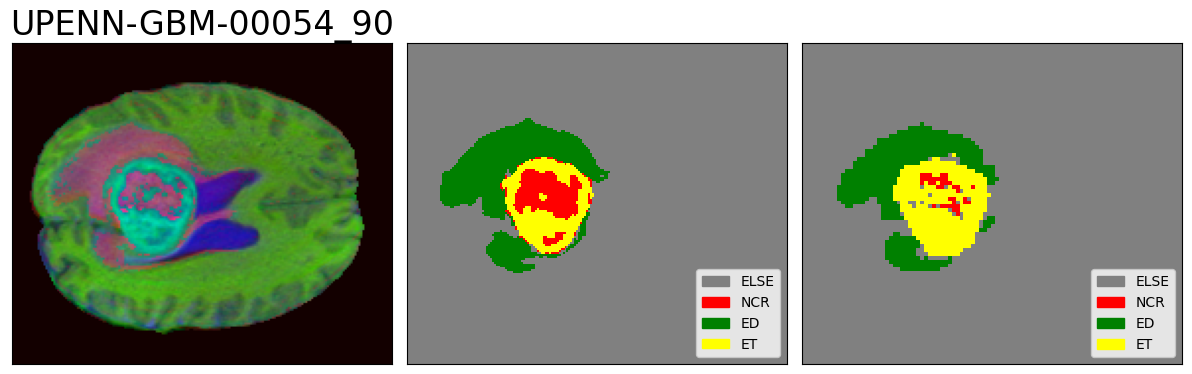

In [39]:
# plot the 2 segmentations
mf_utils.plot_segmentation_comparison(
        input_pixel_values=org_image.numpy(),
        input_segmentation=org_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="lower right")

#### 4.1.3 Calculate metrics on resized sample

In [41]:
# review dimensions and predicitios
all_labels = list(id2label.keys())
print("all segments:", all_labels)

# review dimensions and predictions
print("\nlabels:")
org_input_class_labels = list(org_class_labels.numpy())
print("org_class_labels", org_input_class_labels)
print("pred_class_labels", pred_class_labels)

print("\nsegmentation shapes:")
print("true_mask shape (orig size)", org_mask_labels.shape)
print("pred_mask shape (resized to orig)", pred_mask_labels_rs.shape)
print("note that dimension changes based on the number of labels")

all segments: [0, 1, 2, 3]

labels:
org_class_labels [0, 1, 2, 3]
pred_class_labels [0, 1, 2, 3]

segmentation shapes:
true_mask shape (orig size) torch.Size([4, 163, 193])
pred_mask shape (resized to orig) (4, 163, 193)
note that dimension changes based on the number of labels


In [43]:
# recalculate metrics using resized prediction
calc_slice_metrics(all_labels, id2label, org_mask_labels, pred_mask_labels_rs, org_input_class_labels, pred_class_labels)

Metrics for 0 - ELSE:
Dice Score 0.9892960216271508
HD95 4.242640687119285
Specificity 0.9636686991869918
Sensitivity 0.9839043708898012
Precision 0.9947470888586857
Recall 0.9839043708898012

Metrics for 1 - NCR:
Dice Score 0.35697940503432496
HD95 16.571019681216125
Specificity 1.0
Sensitivity 0.21727019498607242
Precision 1.0
Recall 0.21727019498607242

Metrics for 2 - ED:
Dice Score 0.8639108221086855
HD95 4.0
Specificity 0.9950612202901533
Sensitivity 0.8079930495221547
Precision 0.9281437125748503
Recall 0.8079930495221547

Metrics for 3 - ET:
Dice Score 0.7245557350565428
HD95 5.534594000431324
Specificity 0.9782928985364895
Sensitivity 0.9792576419213974
Precision 0.575
Recall 0.9792576419213974



### 4.2 Make predictions on all data and compute metrics

#### 4.2.0 Initialize variables

In [45]:
# define a transform that downscales predicted masks to original dimension masks
org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

mf_val_inference_upscaled=MaskFormerInference(data_dir=data_dir_val,
                                              model=model,
                                              processor=processor,
                                              upscaled_transform=predict_transform,
                                              orig_transform=org_transform,
                                              scale_to_orig_size=True,
                                              data_type="latent_space_vector",
                                              orig_dim=orig_dim)

print("total validation files", len(mf_val_inference_upscaled.all_files))

mri directory /content/data/lsv_2d_vectors/val/depth
total validation files 4380


In [46]:
# note: scale_to_orig_size is True by default. Im just making it explicit here
start_time = time.time()
pred_target_subj = "UPENN-GBM-00131"
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference_upscaled.predict_patient_mask(subj_id=pred_target_subj)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))


# convert from 255 to 0-1
mask_pred_3d_binary = mf_utils.descale_mask(mask_pred_3d)
mask_true_3d_binary = mf_utils.descale_mask(mask_true_3d)

# instantiate evaluation function to calculate metrics
start_time = time.time()
label_names = list(mri_common.SEGMENTS.values())

orig_dice_score, orig_hausdorff, orig_common_metrics = calc_subject_metrics(
                        label_names=label_names,
                        subj_id=pred_target_subj,
                        mask_pred_binary=mask_pred_3d_binary,
                        mask_true_binary=mask_true_3d_binary)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))


Performing inference on UPENN-GBM-00131
Number of 2d slices for patient 146
Elapsed time: 15.841753 seconds
Calculating metrics for  UPENN-GBM-00131
Elapsed time: 2.661698 seconds


In [48]:
print("dice_score", orig_dice_score)
print("hausdorff_val", orig_hausdorff)
print("sensitivity", orig_common_metrics['sensitivity'])
print("specificity", orig_common_metrics['specificity'])

dice_score [0.9985157616512049, 0.6013986013986014, 0.8175411772882063, 0.649275780067738]
hausdorff_val [1.0, 42.06126462657104, 3.1622776601683795, 4.123105625617661]
sensitivity [0.9976474801989467, 0.5913555992141454, 0.7984416148562431, 0.7195336208273438]
specificity [0.9415207131620346, 0.9996253622968887, 0.9987482938013218, 0.9993217424177845]


#### 4.2.1  Obtain Validation datalist

In [49]:
# Obtain all validation subjects
val_subjs = mf_utils.get_all_subj_ids(data_dir=data_dir_val)
print("total validation data", len(val_subjs))
print("first 5 validation subjects")
val_subjs[:10]

total validation data 30
first 5 validation subjects


['UPENN-GBM-00008',
 'UPENN-GBM-00013',
 'UPENN-GBM-00020',
 'UPENN-GBM-00030',
 'UPENN-GBM-00033',
 'UPENN-GBM-00054',
 'UPENN-GBM-00075',
 'UPENN-GBM-00086',
 'UPENN-GBM-00100',
 'UPENN-GBM-00101']

#### 4.2.5 Calculate Metrics for Validation Data

In [50]:
# UPDATED EVALUATION, downscales predicted masks to original dimension masks
print("val metrics_file_name: ", "upscaled_"+VAL_METRICS_FILENAME)
mf_eval=MaskFormerEvaluation()
val_metrics_dict_upscaled, val_error_files_upscaled, val_success_files_upscaled = mf_eval.predict_and_eval(subj_names=val_subjs,
                                                                                mf_inference=mf_val_inference_upscaled,
                                                                                metrics_dir_prefix=METRICS_DIR_PREFIX,
                                                                                metrics_file_name="upscaled_"+VAL_METRICS_FILENAME,
                                                                                recalculate=RECALCULATE_VAL_METRICS)

val metrics_file_name:  upscaled_metrics_val_sample_training test.joblib
Performing inference on UPENN-GBM-00008
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00008
Performing inference on UPENN-GBM-00013
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00013
Performing inference on UPENN-GBM-00020
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00020
Performing inference on UPENN-GBM-00030
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00030
Performing inference on UPENN-GBM-00033
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00033
Performing inference on UPENN-GBM-00054
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00054
Performing inference on UPENN-GBM-00075
Number of 2d slices for patient 146
Calculating metrics for  UPENN-GBM-00075
Performing inference on UPENN-GBM-00086
Number of 2d slices for patient 146
Calculating metrics for  UPENN-G

#### 4.2.6 Evaluate Validation Data

##### Summary statistics

In [51]:
# updated evaluation, by transforming predicted masks to original dimension masks
mf_eval.display_statistics(val_metrics_dict_upscaled)

Summary: precision
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.998896   0.599078   0.798185   0.697112
std     0.000816   0.246044   0.158224   0.181420
min     0.996261   0.000000   0.286756   0.000000
25%     0.998582   0.426428   0.793406   0.583200
50%     0.999111   0.624802   0.846806   0.743553
75%     0.999445   0.763200   0.877331   0.822620
max     0.999880   0.948284   0.955321   0.916209


Summary: recall
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.995730   0.661333   0.718371   0.703238
std     0.003942   0.196075   0.166554   0.184685
min     0.983741   0.000000   0.227960   0.000000
25%     0.994391   0.591383   0.665638   0.638912
50%     0.996428   0.693621   0.760027   0.715204
75%     0.998230   0.795344   0.808856   0.821621
max     0.999803   0.923561   0.922226   0.972326


Summary: sensitivity
            ELSE        NCR         ED  

Final report metric summary

In [52]:
val_mean_scores_upscaled = mf_eval.get_mean_scores(val_metrics_dict_upscaled)
val_mean_scores_upscaled

,ELSE,NCR,ED,ET
dice_score,0.997306,0.602988,0.738759,0.686952
hd95,1.007215,10.309052,10.484043,5.433214
sensitivity,0.995730,0.661333,0.718371,0.703238
specificity,0.899238,0.999402,0.998008,0.999150


Box plots

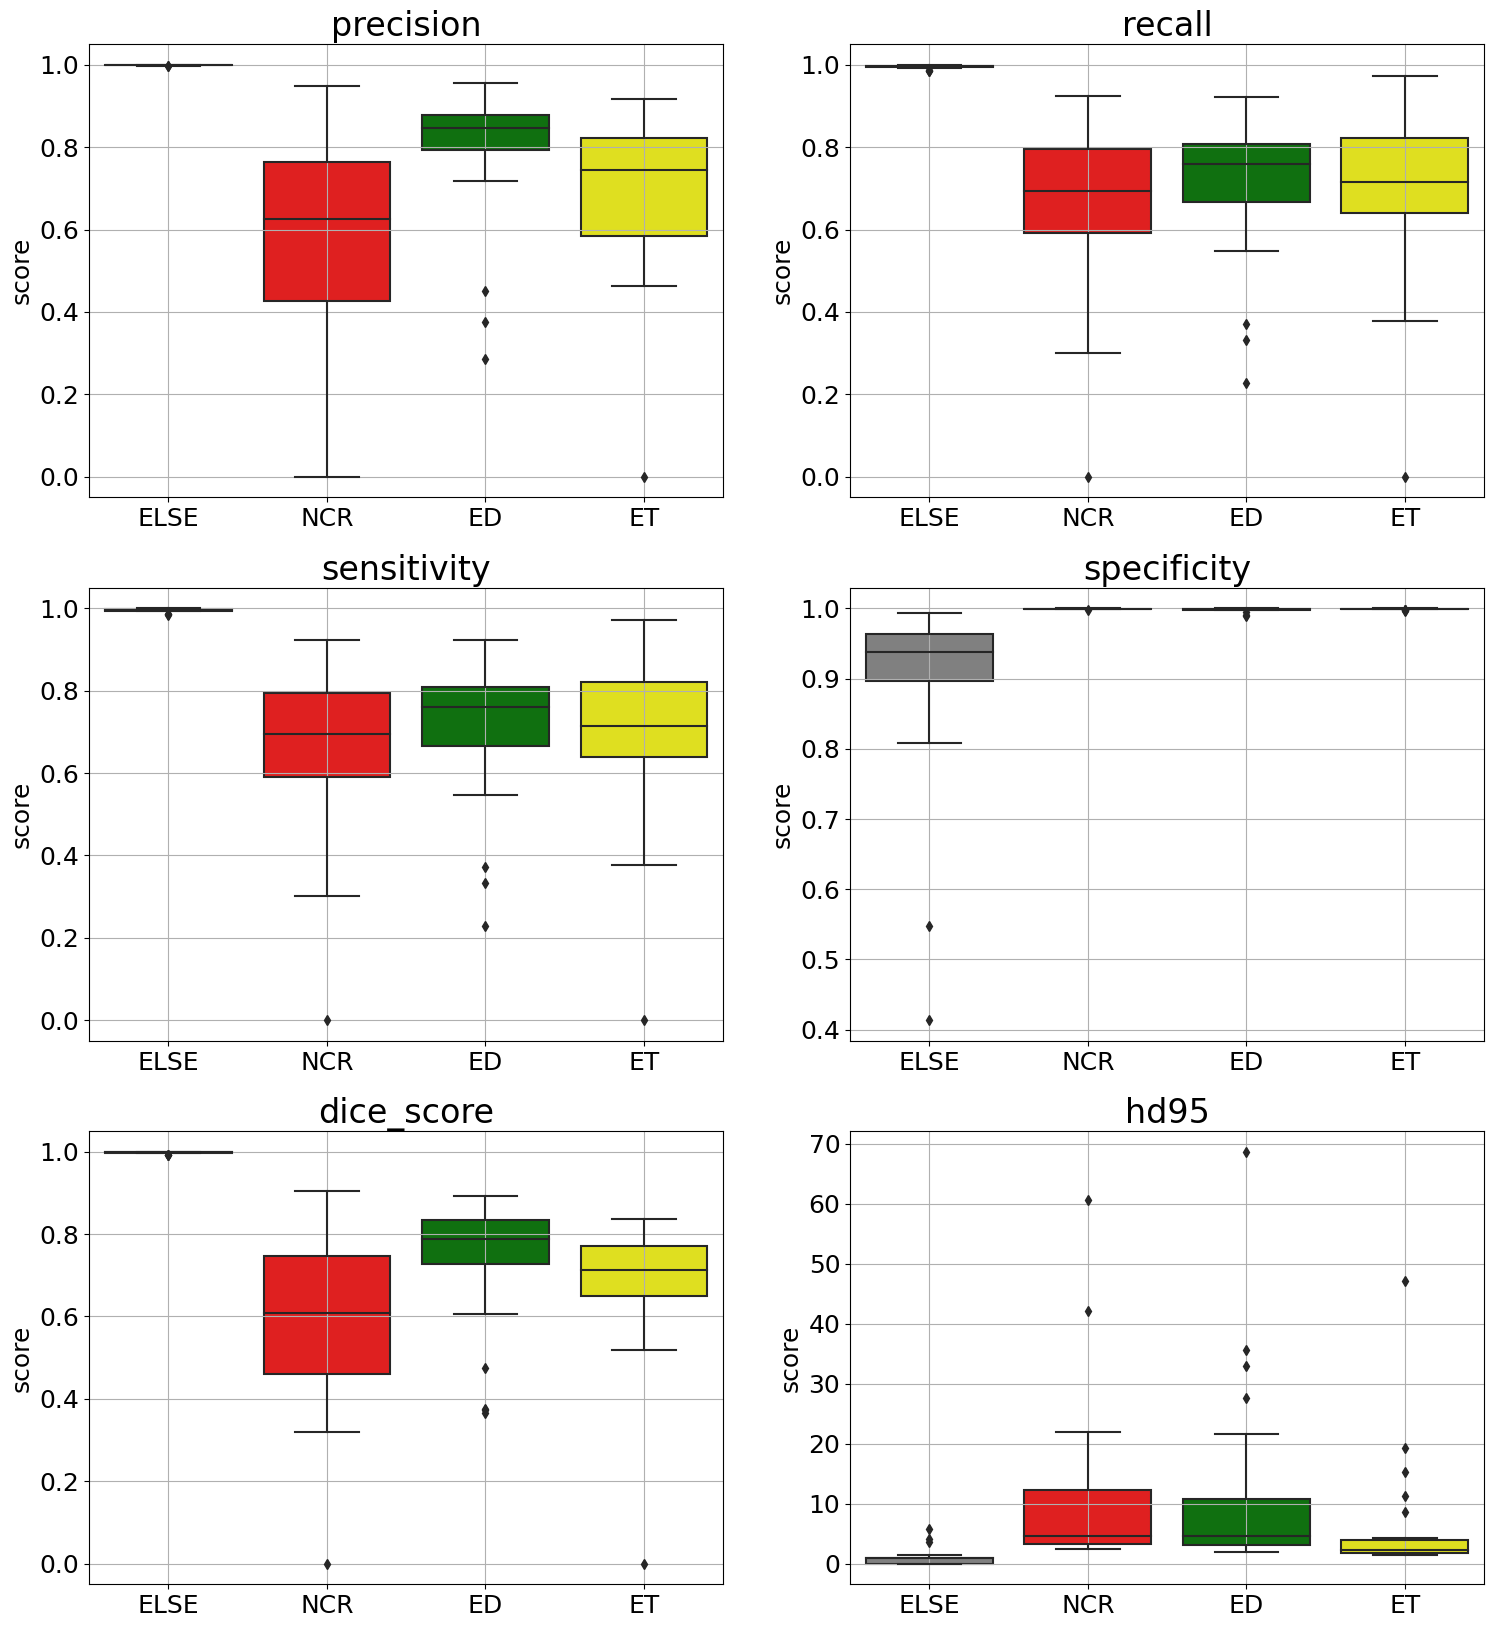

In [53]:
mf_eval.draw_box_plots(val_metrics_dict_upscaled)

Histograms

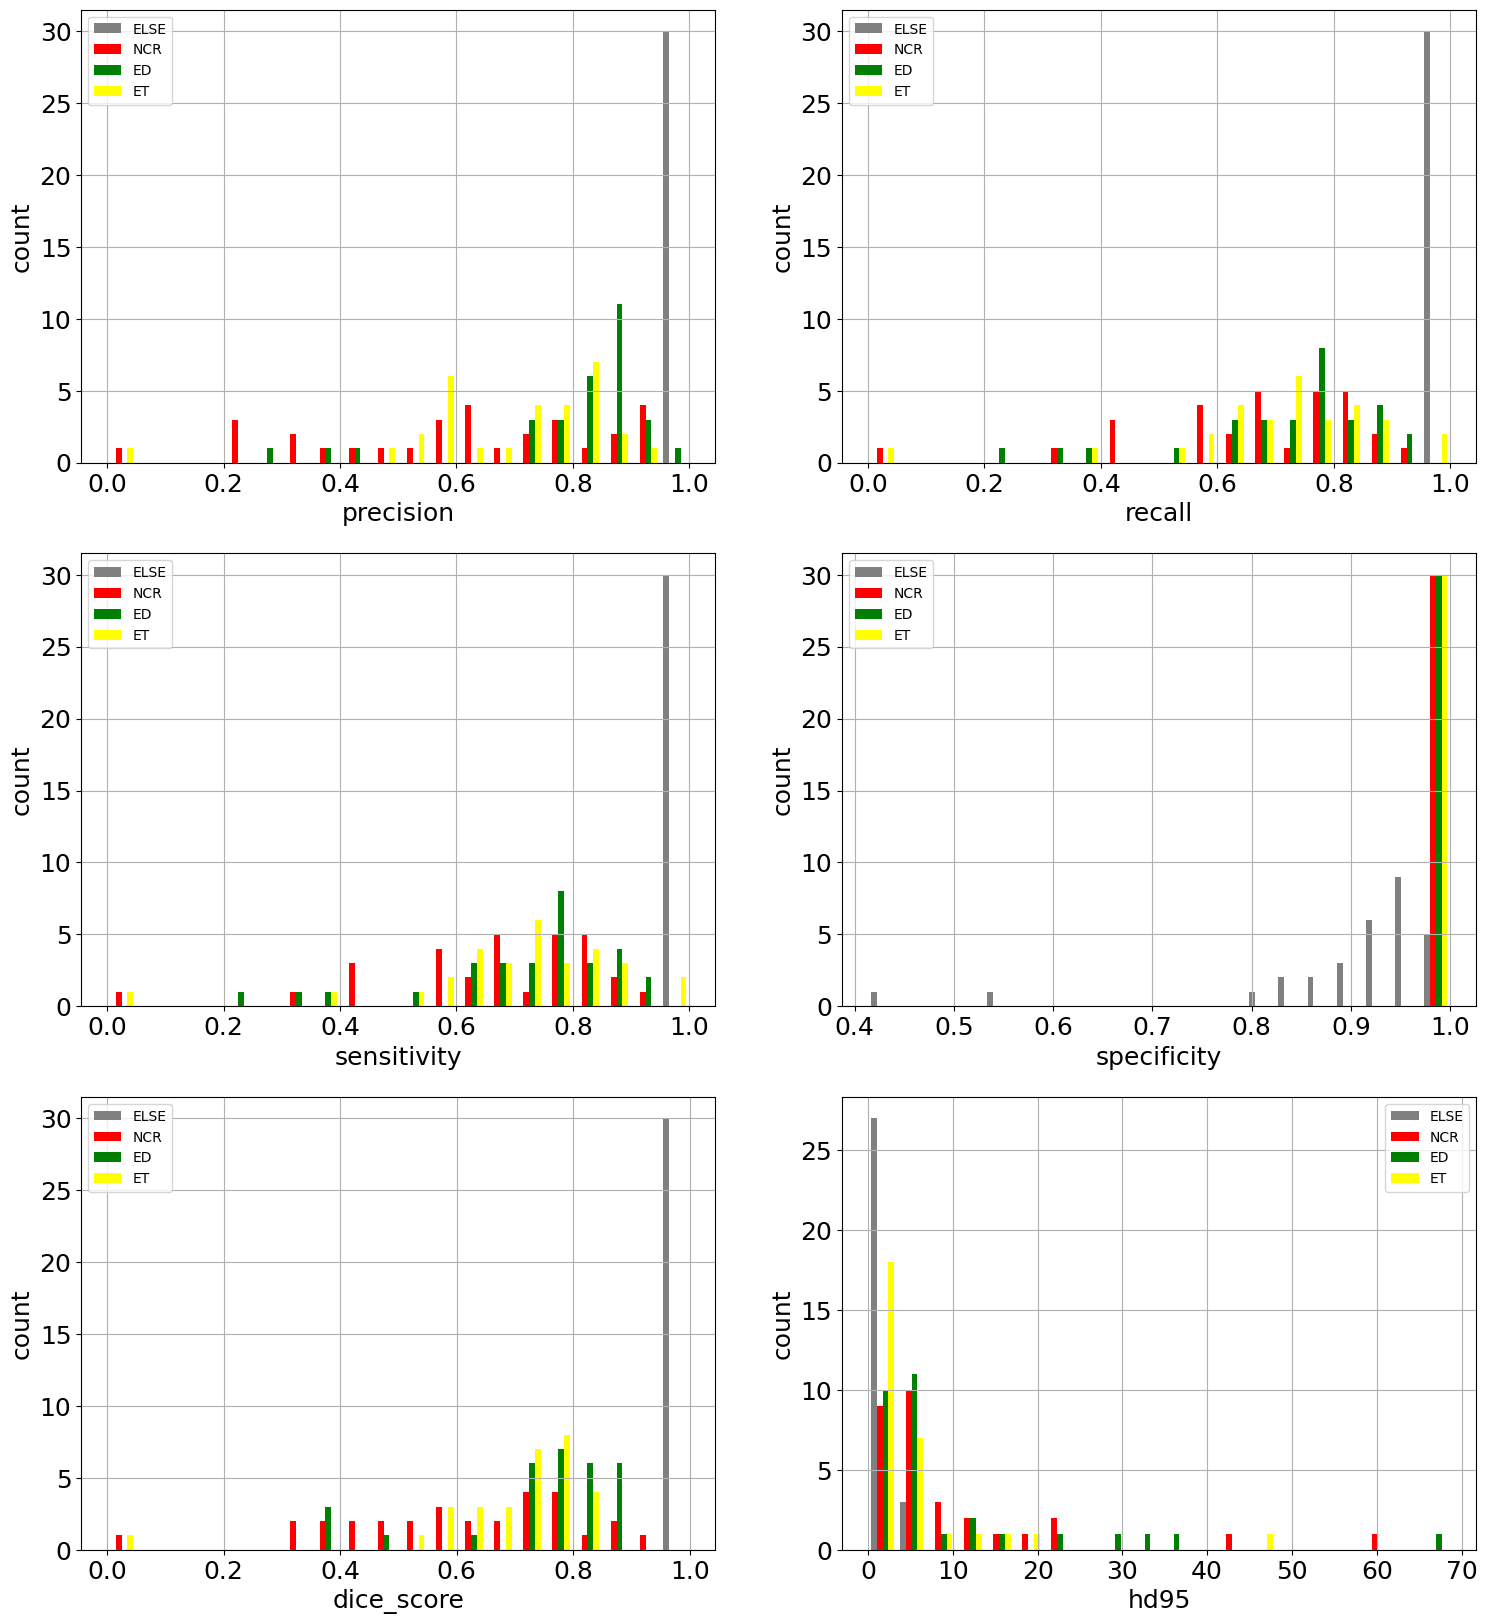

In [54]:
mf_eval.build_histogram(val_metrics_dict_upscaled)

##### Worst Dice Score

In [55]:
# column label id corresponds to the specific segment which got the lowest score: i.e. Label 1 = NCR
low_dice_score_val = mf_eval.get_low_dice_score_images(val_success_files_upscaled, val_metrics_dict_upscaled, top_n=5)
low_dice_score_val

,subj_name,dataset_idx,label_id,score
0,UPENN-GBM-00380,27,1,0.000000
1,UPENN-GBM-00380,27,3,0.000000
2,UPENN-GBM-00474,29,1,0.318713
3,UPENN-GBM-00249,21,1,0.330482
4,UPENN-GBM-00140,14,2,0.366401


##### Worst HD95

In [56]:
high_hd95_val = mf_eval.get_high_hd95_images(val_subjs, val_metrics_dict_upscaled, top_n=5)
high_hd95_val

,subj_name,dataset_idx,label_id,score
0,UPENN-GBM-00013,1,2,68.663309
1,UPENN-GBM-00206,18,1,60.724788
2,UPENN-GBM-00380,27,3,47.212696
3,UPENN-GBM-00131,13,1,42.061265
4,UPENN-GBM-00206,18,2,35.651084


##### Plot image with low dice score

In [58]:
low_dice_img = low_dice_score_val.loc[0]['subj_name']
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference_upscaled.predict_patient_mask(subj_id=low_dice_img)


Performing inference on UPENN-GBM-00380
Number of 2d slices for patient 146


100%|██████████| 1.46G/1.46G [00:37<00:00, 39.1MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 735/735 [00:08<00:00, 86.15it/s]


Slice 55


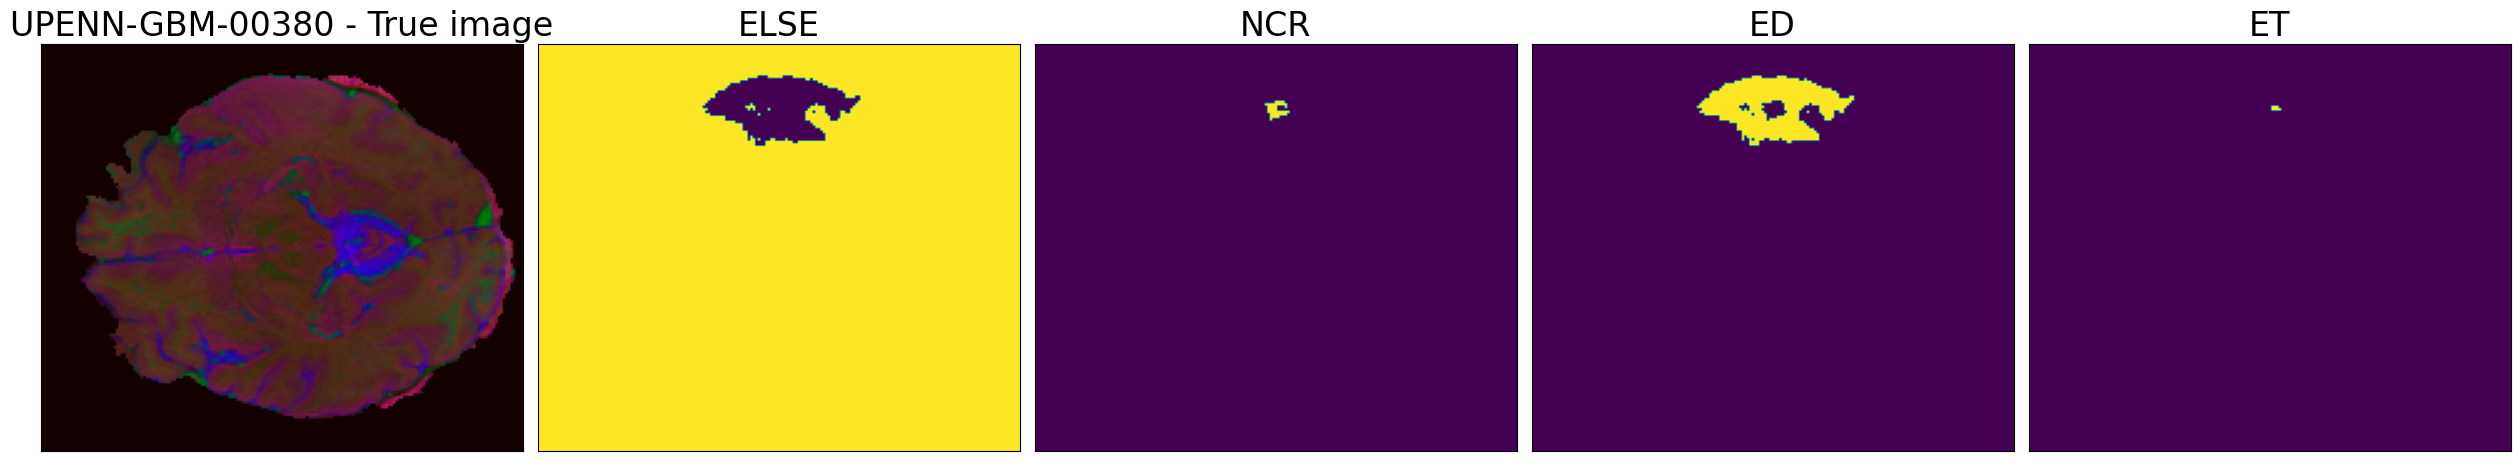

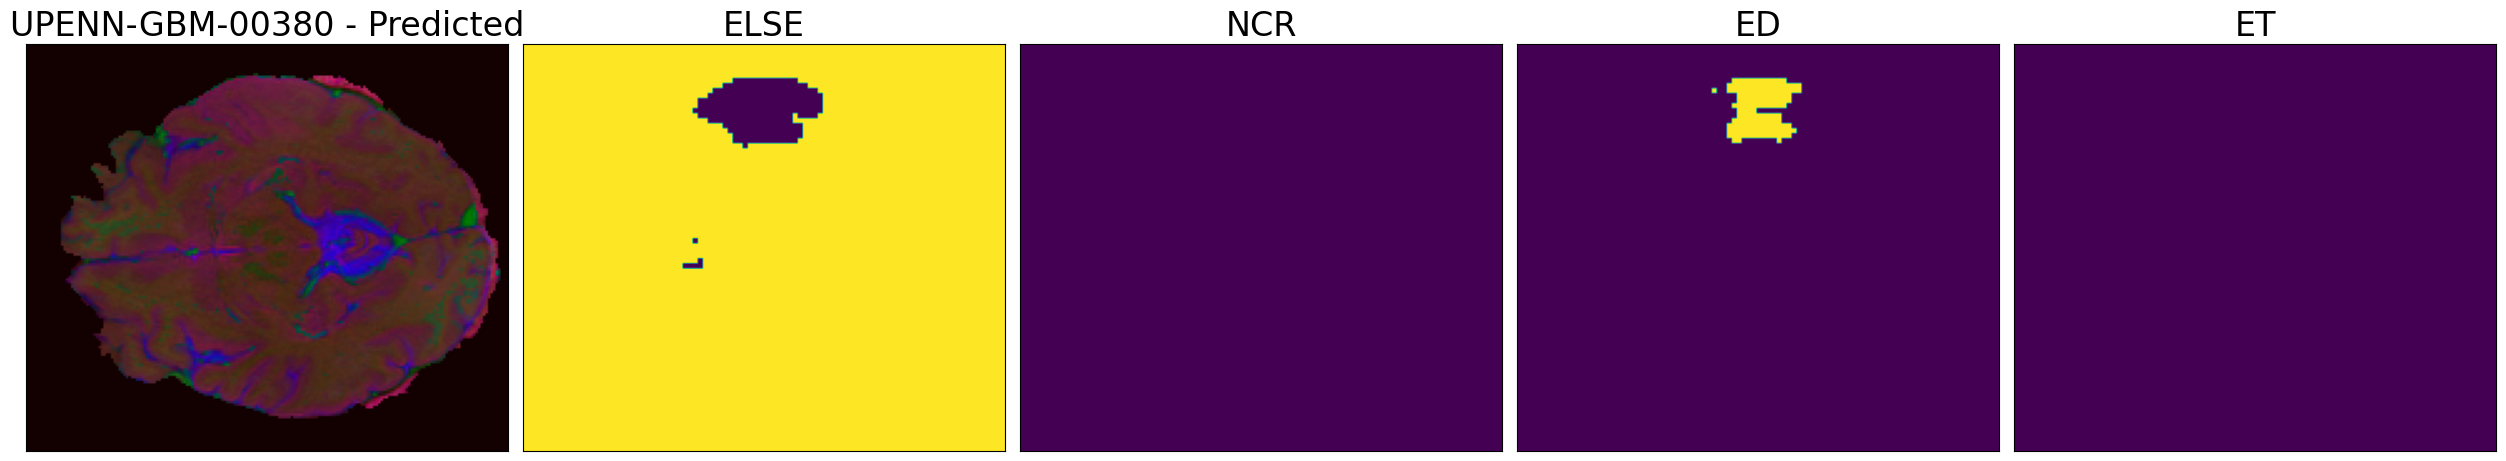

In [59]:
# load annotated file
actual_file = data_handler.load_mri(low_dice_img, mri_type=MriType.ANNOTATED_REDUCED)

# get largest tumor slice for visualization
slice_idx = mri_common.get_largest_tumor_slice_idx(actual_file)[0]

print("Slice", slice_idx)
mf_utils.plot_mask_labels(class_labels = true_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_true_3d[:, slice_idx, :, :],
             title = f"{low_dice_img} - True image",)

mf_utils.plot_mask_labels(class_labels = pred_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_pred_3d[:, slice_idx, :, :],
             title = f"{low_dice_img} - Predicted",)

input segmentation shape: (163, 193)
pred segmentation shape: (163, 193)


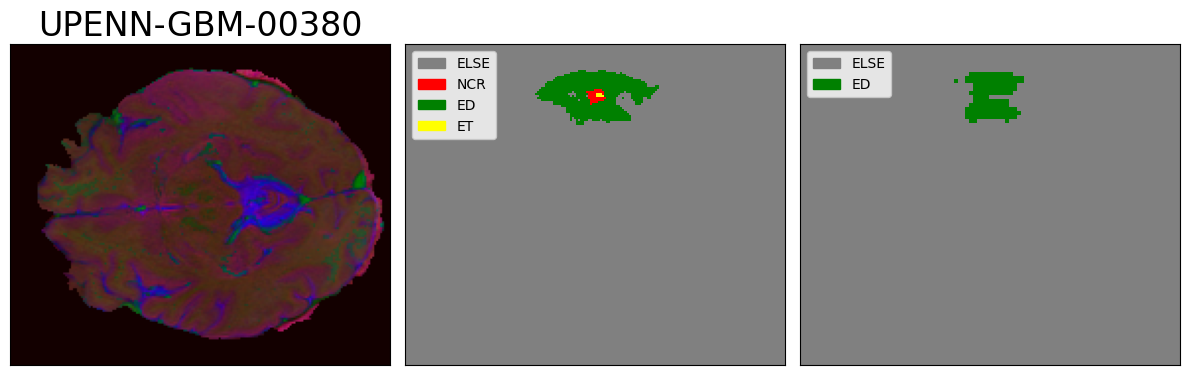

In [61]:
# compare segmentation
input_segmentation = mf_utils.mask_to_segmentation(mask_labels=mask_true_3d[:, slice_idx, :, :], class_labels=true_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=mask_pred_3d[:, slice_idx, :, :], class_labels=pred_class_labels)
print("input segmentation shape:", input_segmentation.shape)
print("pred segmentation shape:", pred_segmentation.shape)

# cut the 3d image using the slice
mf_utils.plot_segmentation_comparison(
            input_pixel_values=image_3d[slice_idx, :, :, :],
            input_segmentation=input_segmentation,
            pred_segmentation=pred_segmentation,
            title=low_dice_img, loc="upper left")

## DEBUG

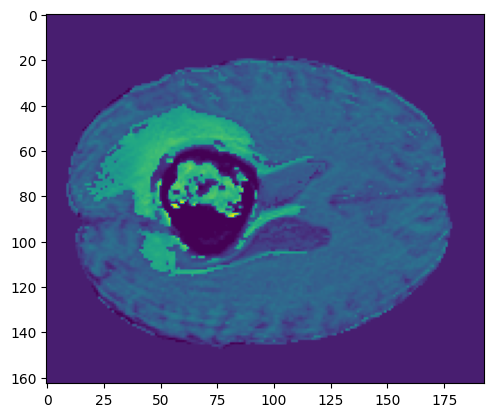

In [6]:
upenn54_lv1 = data_handler.load_mri("UPENN-GBM-00054", mri_type=MriType.LATENT_SPACE_VECTORS_NORM,
                                    struct_scan=LatentVector.LATENT_VECTOR_1, dataset_type="val")
plt.imshow(upenn54_lv1[:, :, 90])
plt.show()

100%|██████████| 1.46G/1.46G [00:34<00:00, 42.3MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 738/738 [00:10<00:00, 73.29it/s]


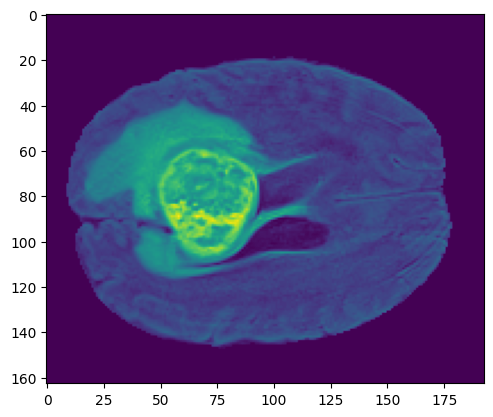

In [10]:
flair_img = data_handler.load_mri("UPENN-GBM-00054", mri_type=MriType.ANNOTATED_REDUCED_NORM,
                                    struct_scan=StructuralScan.FLAIR, dataset_type="val")
plt.imshow(flair_img[:, :, 90])
plt.show()